# Close encounters with MERCURANA
In this tutorial, we run a simulation in which particles in a disk undergo close encounters with a planets. The disk particles are test particles (they have no mass). This reduces the complexity of the simulation from  $\mathcal{O}(N^2)$ to $\mathcal{O}(N)$.

We use the MERCURANA integrator for this example. We configure it in the simplest way possible. Some optimization can be made, which we comment on at the end.

Let's first set up a REBOUND simulation with one star and two planets, then move to the center of mass fram.

In [1]:
import numpy as np
import rebound
sim = rebound.Simulation()
sim.add(m=1.)
sim.add(m=1e-3, a=1, e=0.05)
sim.add(m=1e-3, a=1.8, e=0.05)
sim.move_to_com()

Next, we'll add the disk particles. 

In [2]:
N_testparticle = 1000
a_initial = np.linspace(0.8, 2, N_testparticle)
for a in a_initial:
    sim.add(a=a,f=np.random.rand()*2.*np.pi) # mass is set to 0 by default, random true anomaly   

Next, we set the `N_active` variable of REBOUND to the number of active particles in our simulation. Here, we have threee active (massive) particles, the star and the two planets.

In [3]:
sim.N_active = 3

We can configure the MERCURANA ingtegrator. In this example, we use the standard second order leapfrog for all embedded operator splittings. We use two substeps per shell and set the accuracy control parameter $\kappa$ to 0.01. We set the maxiumum number of shells to 20. Note that we only specify these parameters for the outermost splitting (shell 0). If we do not specifically set the parameters for the innter shells, all shells use the same parameters.

In [4]:
sim.integrator = "mercurana"
sim.ri_mercurana.phi0 = "lf"
sim.ri_mercurana.n0 = 2
sim.ri_mercurana.kappa0 = 0.01
sim.ri_mercurana.Nmaxshells = 20

Before we start the integration, let us plot the initial conditions with the OrbitPlot function.

In [5]:
rebound.OrbitPlot(sim,orbit_type=None)

(<Figure size 500x500 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11612d240>)

Next, let's run the simulation. We use a global timestep of 0.01 of the inner planet's orbit asnd will run it for 200 orbits of the inner planet.

In [6]:
P0 = sim.particles[1].P
sim.dt = 0.01*P0
sim.integrate(200.*P0)

And let's plot the particles again.

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1181f2400>)

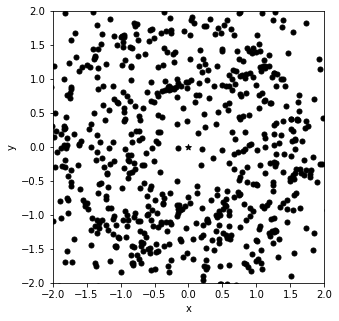

In [7]:
rebound.OrbitPlot(sim,orbit_type=None,xlim=[-2,2],ylim=[-2,2])

We can see that the planets stirred up the disk quite a bit. The particles in our simulation have not size, they are point particles. This allows for arbitrarily close encounters. We can check if the number of shells we used was sufficient by looking at the deepest shell we used:

In [8]:
sim.ri_mercurana.Nmaxshellused

20

But 20 is the number of maximum shells we set at the beginning of the simulation. So we need to assume that the dynamics on the smallest scales are not resolved accuratetly. Let's see what this shortest scale is. In MERCURANA the critical radii are based on particle mass. Let's look at the smallest critical radii of the inner planet (index 1). This will give us some idea about the smallest scale we can accurately resolve:

In [10]:
sim.ri_mercurana._dcrit[19][1]  # 19 because we're starting to count at 

2.3646239500729174e-08

This length is returned in code units. If we choose units corresponding to $G=1$, and solar masses, then this length scale is about 150m, i.e. much smaller than the size of any planet. To improve the simulation we should therefore consider including a model of collisions.

So we'll set up the same simulation again, but this time set the radii of all massive particles to something meaningful. We don't add a radius to the test-particles because we assume they will not collide with each other.

In [14]:
sim = rebound.Simulation()
sim.add(m=1., r=0.0047)
sim.add(m=1e-3, a=1, e=0.05, r=0.00047)
sim.add(m=1e-3, a=1.8, e=0.05, r=0.00047)
sim.move_to_com()
for a in a_initial:
    sim.add(a=a,f=np.random.rand()*2.*np.pi) 
sim.N_active = 3    

We setup a direct collision search (this will be handled by the MERCURANA integrator) and assume collisions are perfect mergers. We also want to keep the particles sorted.

In [17]:
sim.collision = "direct"
sim.collision_resolve = "merge"
sim.collision_resolve_keep_sorted = True

The integrator settings are the same as before.

In [18]:
sim.integrator = "mercurana"
sim.ri_mercurana.phi0 = "lf"
sim.ri_mercurana.n0 = 2
sim.ri_mercurana.kappa0 = 0.01
sim.ri_mercurana.Nmaxshells = 20

Let's integrate this again.

In [19]:
sim.dt = 0.01*P0
sim.integrate(200.*P0)

Note that we have lost a lot of particles (we started with 1003):

In [20]:
sim.N

733

Let's check what the maximum number of shells used was this time:

In [21]:
sim.ri_mercurana.Nmaxshellused

10

So we only used 10 out of 20 shells. This means the dynamics on the smallest scales are accurately resolved. To further increase the accuracy, we could reduce $\kappa$, or use a higher order splitting method instead of leap-frog.